In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# load the dataloader
from torch.utils.data import DataLoader

In [10]:
# import dataset 
import seaborn as sns
iris = sns.load_dataset('iris')

In [4]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [5]:
# splitting the data into training and testing splits
train_data, test_data, train_labels, test_labels = train_test_split(data, labels,test_size = 0.2)

# train tensor dataset
train_dataset = TensorDataset(train_data, train_labels)

# test tensor dataset
test_dataset = TensorDataset(test_data, test_labels)


In [6]:
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([8, 4]) torch.Size([8])


In [7]:
def createANewModel():

    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3)
    )

    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = 0.0005)
    return ANNiris, lossfun, optimizer


In [8]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel():

    # initialize accuracies as empties
    trainAcc = []
    testAcc  = []
    losses   = []

    # loop over epochs
    for epochi in range(numepochs):

      # need to toggle train mode here??

      # loop over training data batches
      batchAcc  = []
      batchLoss = []
      for X,y in train_loader:

          # forward pass and loss
          yHat = ANNiris(X)
          loss = lossfun(yHat,y)
          
          # backprop
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # compute training accuracy just for this batch
          batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
          batchLoss.append( loss.item() )
        # end of batch loop...

      # now that we've trained through the batches, get their average training accuracy
      trainAcc.append( np.mean(batchAcc) )
      losses.append( np.mean(batchLoss) )

      # test accuracy
      ANNiris.eval()
      X,y = next(iter(test_loader)) # extract X,y from test dataloader
      predlabels = torch.argmax( ANNiris(X),axis=1 )
      testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

      # no worries, reset here ;)
      ANNiris.train() 
  
  # function output
    return trainAcc,testAcc,losses



In [9]:
# global parameter
numepochs = 1000

batchsizes = 2**np.arange(1,7)

test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])


# initialize output result matrices
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest = np.zeros((numepochs,len(batchsizes)))

for bi in range(len(batchsizes)):
    train_loader = DataLoader(train_dataset, batch_size=int(batchsizes[bi]),drop_last=True)

    ANNiris, lossfun, optimizer = createANewModel()
    trainAcc, testAcc, losses = trainTheModel()


    accuracyResultsTrain[:,bi] = trainAcc
    accuracyResultsTest[:,bi] = testAcc
    
    



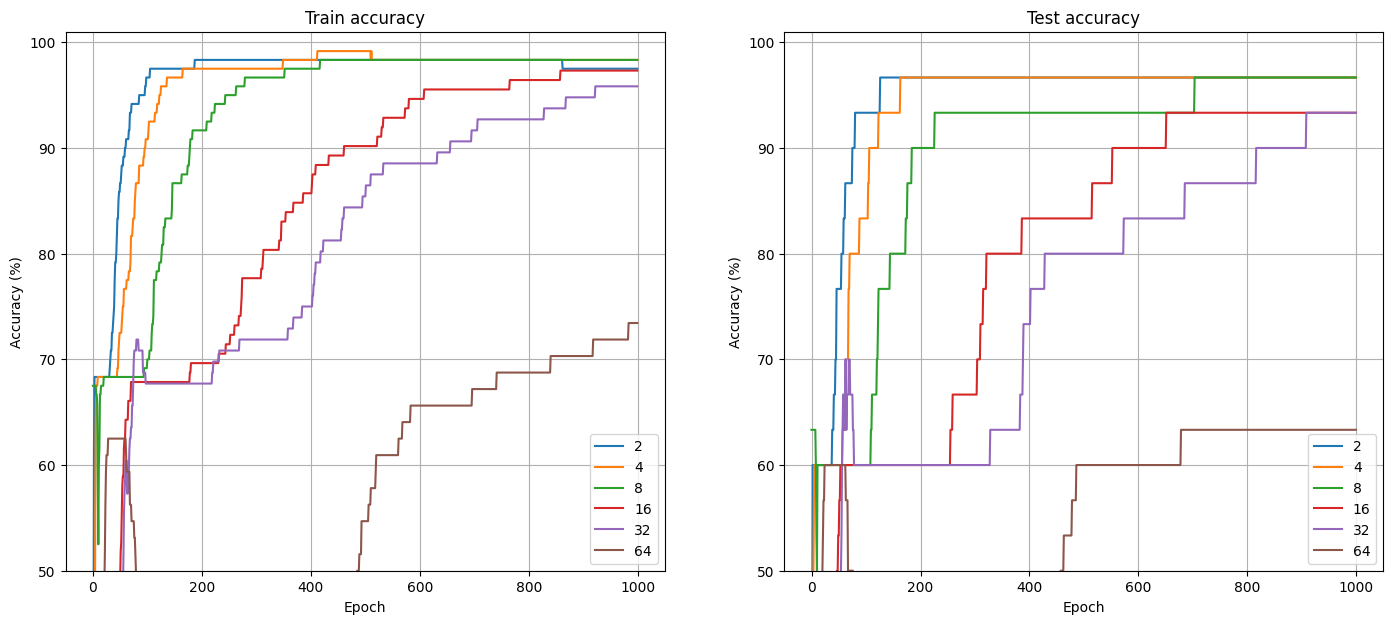

In [11]:

# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()